# Деревья принятия решений

In [3]:
import numpy  as np
import pandas as pd

df = pd.read_csv("data/raw/chips.csv")
print(f"* X:\nmin    {df['x'].min()}\nmax    {df['x'].max()}\nmean   {round(df['x'].mean(), 5)}")
print(f"* Y:\nmin    {df['y'].min()}\nmax    {df['y'].max()}\nmean   {round(df['y'].mean(), 5)}")
print(f"* Классы:\n0    {len(df['class'].loc[df['class'] == 0])}\n1    {len(df['class'].loc[df['class'] == 1])}")

* X:
min    -0.83007
max    1.0709
mean   0.05478
* Y:
min    -0.76974
max    1.1089
mean   0.1831
* Классы:
0    60
1    58


## Дерево решений

Построем модель, которую будем применять

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

def accuracy(model, size=0.15):
    train, test = train_test_split(df, test_size=size, random_state=0)
    model.fit(train.drop(columns=["class"]).values, train["class"].values)

    prediction = model.predict(test.drop(columns=["class"]).values)
    fpr, tpr, _ = roc_curve(test["class"], prediction)
    return auc(fpr, tpr)

Настроим визуализацию на примере дерева без ограничения глубины

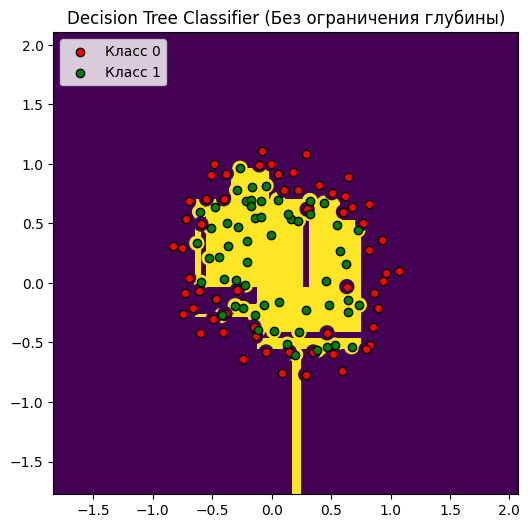

* AUC:  0.7875


In [5]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

def test_model(model, X, y, cmap=None, fit_model=False):
    xx,yy = get_grid(X.values)
    if fit_model:
        model.fit(X.values, y)

    predicted = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.figure(figsize=(6, 6))
    plt.pcolormesh(xx, yy, predicted)
    plt.scatter(X.values[:, 0], X.values[:, 1], c=y, s=100)
    if fit_model:
        return model

def run_tree_model(title="", max_depth=None, graph=False):
    model = DecisionTreeClassifier(max_depth=max_depth)
    model.fit(df.drop(columns=["class"]).values, df["class"])
    acc = accuracy(model)
    
    if graph:
        test_model(model, df.drop(columns=["class"]), df["class"])
        plt.title(title)
        plt.scatter(df['x'].loc[df['class']==0], df['y'].loc[df['class']==0], color='r', label="Класс 0", edgecolors='black')
        plt.scatter(df['x'].loc[df['class']==1], df['y'].loc[df['class']==1], color='g', label="Класс 1", edgecolors='black')
        plt.legend(loc="upper left")
        plt.show()
        print("* AUC: ", acc)
    return acc
    
_ = run_tree_model("Decision Tree Classifier (Без ограничения глубины)", graph=True)

### Точность классификации от глубины рекурсии

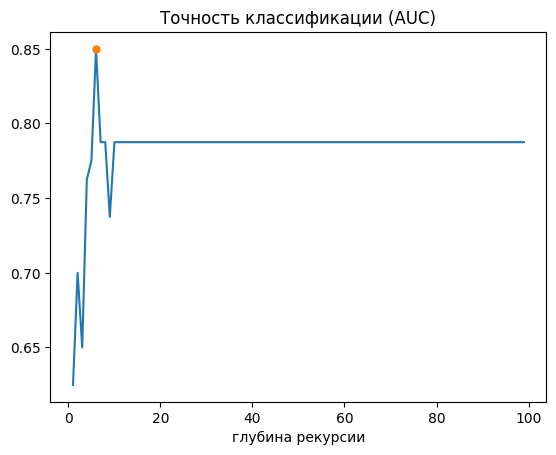

* Best: depth=6, auc=0.85


In [6]:
xs = np.arange(1, 100, 1)
ys = []
for x in xs:
    ys.append(run_tree_model("", x))

max_ind = ys.index(max(ys))
plt.plot(xs, ys)
plt.plot(xs[max_ind], ys[max_ind], marker="o", markersize=5)
plt.title("Точность классификации (AUC)")
plt.xlabel("глубина рекурсии")
plt.show()
print(f"* Best: depth={xs[max_ind]}, auc={ys[max_ind]}")

После некоторой отметки можно увидеть, что увеличивать максимальную глубину не имеет смысла.


### Дерево принятия решений с оптимальной глубиной

* Узлы - условие ветвления (признаки)
* Ребра - да/нет
* Листья - конечные значения попадающие/не попадающие под условия

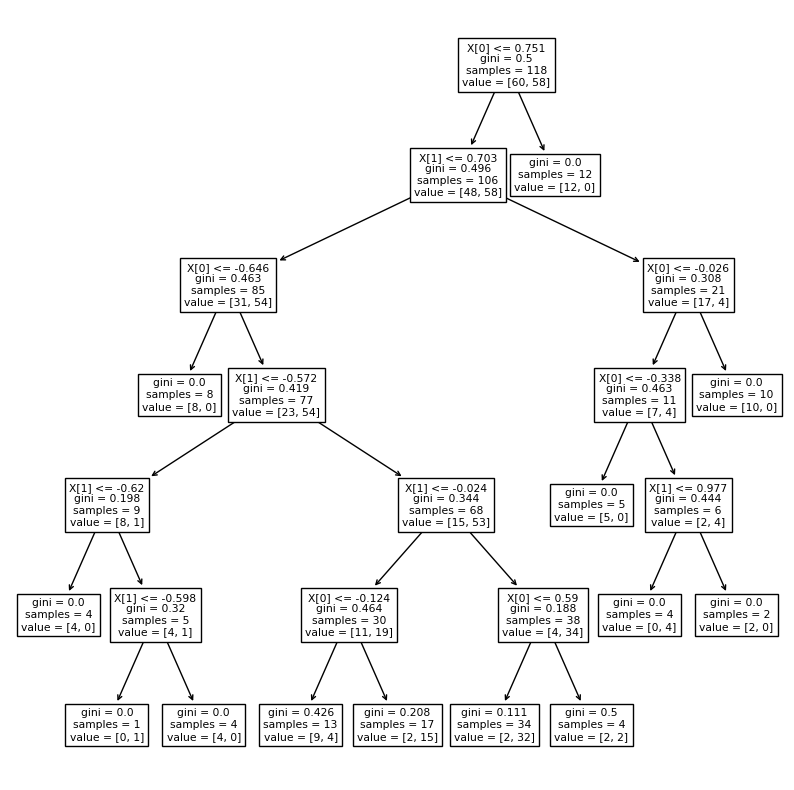

In [8]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth=xs[max_ind])
clf.fit(df.drop(columns=["class"]), df["class"])

plt.figure(figsize=(10, 10))
tree.plot_tree(clf)
plt.show()

## Случайный лес

* Строится n деревьев решения на случайной повторной подвыборке исходных данных
* Задача классификации решается голосованием (точка принадлежит классу, в который попала чаще всего)

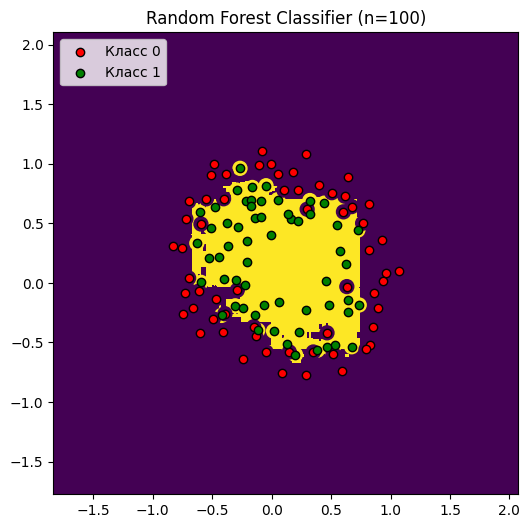

* AUC:  0.7946428571428571


In [287]:
from sklearn.ensemble import RandomForestClassifier

def plot_predicted(title, predicted):
    xx,yy = get_grid(df.drop(columns=["class"]).values)
    plt.figure(figsize=(6, 6))
    plt.pcolormesh(xx, yy, predicted)
    plt.scatter(df.drop(columns=["class"]).values[:, 0], df.drop(columns=["class"]).values[:, 1], c=df["class"], s=100)

    plt.title(title)
    plt.scatter(df['x'].loc[df['class']==0], df['y'].loc[df['class']==0], color='r', label="Класс 0", edgecolors='black')
    plt.scatter(df['x'].loc[df['class']==1], df['y'].loc[df['class']==1], color='g', label="Класс 1", edgecolors='black')
    plt.legend(loc="upper left")
    plt.show()

def run_forest_model(title="", trees=100, graph=False, needs_fit=True, model=None):
    if needs_fit:
        model = RandomForestClassifier(n_estimators=trees)
        model.fit(df.drop(columns=["class"]).values, df["class"])
    acc = accuracy(model, 0.25)
    
    xx,yy = get_grid(df.drop(columns=["class"]).values)
    predicted = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    if graph:
        plot_predicted(title, predicted)
        print("* AUC: ", acc)
    return acc, predicted

_ = run_forest_model("Random Forest Classifier (n=100)", 100, True)

### Тоность классификации

На каждой $i$ итерации алгоритм строит $i$ деревьев, а потом такой перебор строит $n(n + 1) / 2$, $O(n^2)$ где $n$ - перебираемое число деревьев и это работает медленно ._.

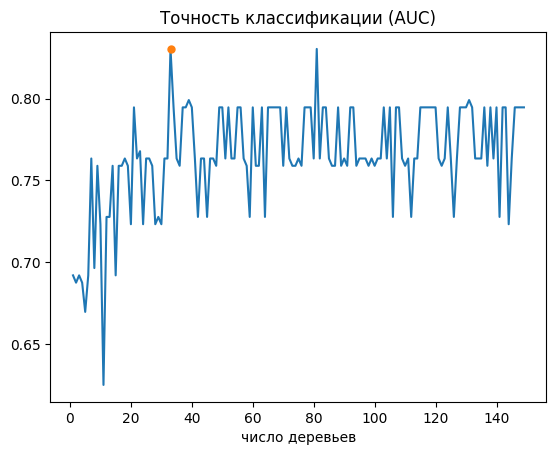

* Best: trees=33, auc=0.8303571428571429


In [304]:
xs = np.arange(1, 150, 1)
ys = []
preds = []
for x in xs:
    a, p = run_forest_model("", x)
    ys.append(a)
    preds.append(p)

max_ind = ys.index(max(ys))
plt.plot(xs, ys)
plt.plot(xs[max_ind], ys[max_ind], marker="o", markersize=5)
plt.title("Точность классификации (AUC)")
plt.xlabel("число деревьев")
plt.show()
print(f"* Best: trees={xs[max_ind]}, auc={ys[max_ind]}")

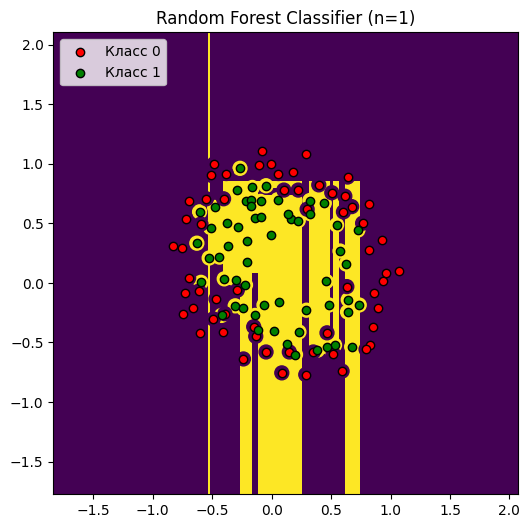

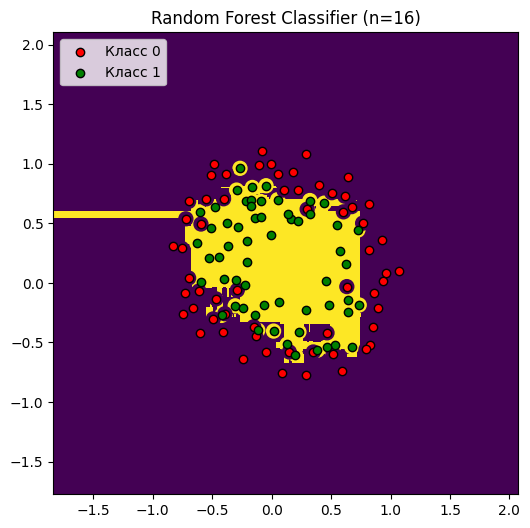

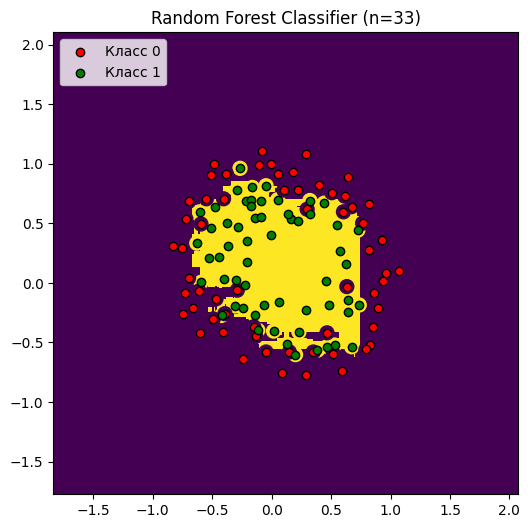

In [305]:
_ = plot_predicted("Random Forest Classifier (n=1)", preds[0])
_ = plot_predicted(f"Random Forest Classifier (n={max_ind // 2})", preds[max_ind // 2])
_ = plot_predicted(f"Random Forest Classifier (n={xs[max_ind]})", preds[max_ind])

## Adaptive Boost

* Алгоритм делает предсказание с помощью дерева решений с глубиной 1
* Далее n раз строится лес деревьев решений на основе объектов, неверно классифицированных на предыдущем шаге

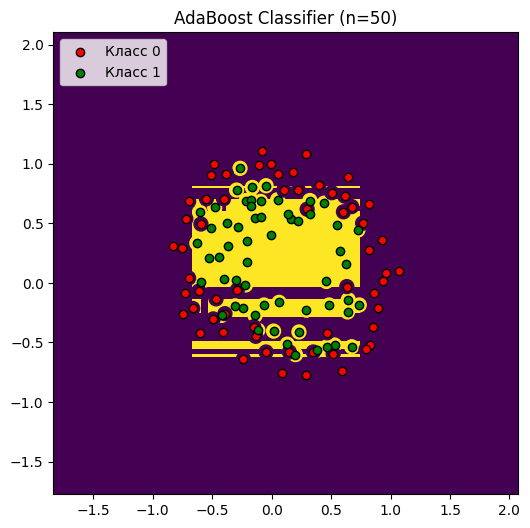

* AUC:  0.7633928571428572


In [310]:
from sklearn.ensemble import AdaBoostClassifier

def plot_predicted(title, predicted):
    xx,yy = get_grid(df.drop(columns=["class"]).values)
    plt.figure(figsize=(6, 6))
    plt.pcolormesh(xx, yy, predicted)
    plt.scatter(df.drop(columns=["class"]).values[:, 0], df.drop(columns=["class"]).values[:, 1], c=df["class"], s=100)

    plt.title(title)
    plt.scatter(df['x'].loc[df['class']==0], df['y'].loc[df['class']==0], color='r', label="Класс 0", edgecolors='black')
    plt.scatter(df['x'].loc[df['class']==1], df['y'].loc[df['class']==1], color='g', label="Класс 1", edgecolors='black')
    plt.legend(loc="upper left")
    plt.show()

def run_boost_model(title="", trees=50, graph=False, needs_fit=True, model=None):
    if needs_fit:
        model = AdaBoostClassifier(n_estimators=trees)
        model.fit(df.drop(columns=["class"]).values, df["class"])
    acc = accuracy(model, 0.25)
    
    xx,yy = get_grid(df.drop(columns=["class"]).values)
    predicted = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    if graph:
        plot_predicted(title, predicted)
        print("* AUC: ", acc)
    return acc, predicted

_ = run_boost_model("AdaBoost Classifier (n=50)", 50, True)

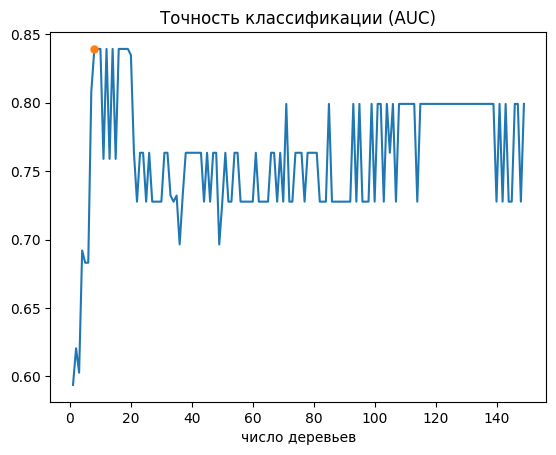

* Best: trees=8, auc=0.8392857142857143


In [311]:
xs = np.arange(1, 150, 1)
ys = []
preds = []
for x in xs:
    a, p = run_boost_model("", x)
    ys.append(a)
    preds.append(p)

max_ind = ys.index(max(ys))
plt.plot(xs, ys)
plt.plot(xs[max_ind], ys[max_ind], marker="o", markersize=5)
plt.title("Точность классификации (AUC)")
plt.xlabel("число деревьев")
plt.show()
print(f"* Best: trees={xs[max_ind]}, auc={ys[max_ind]}")

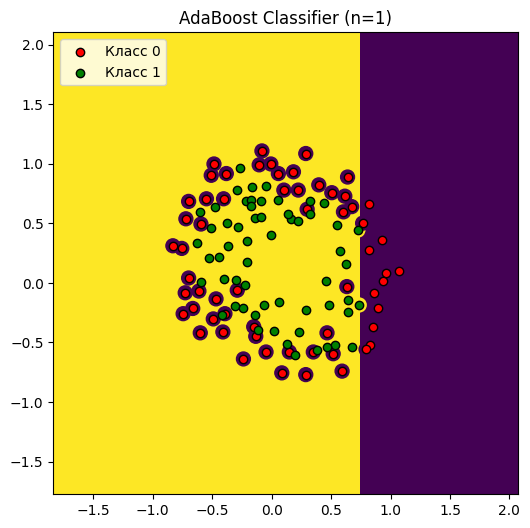

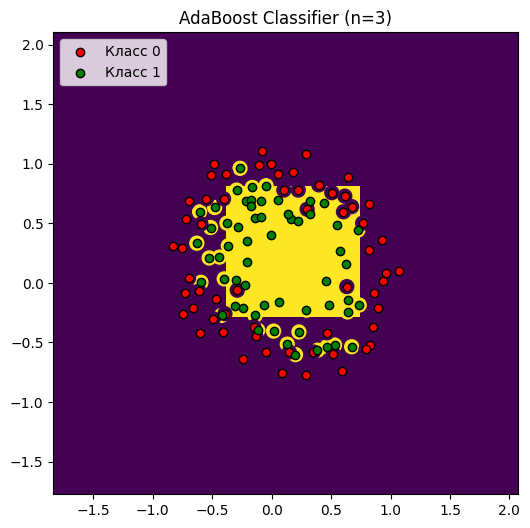

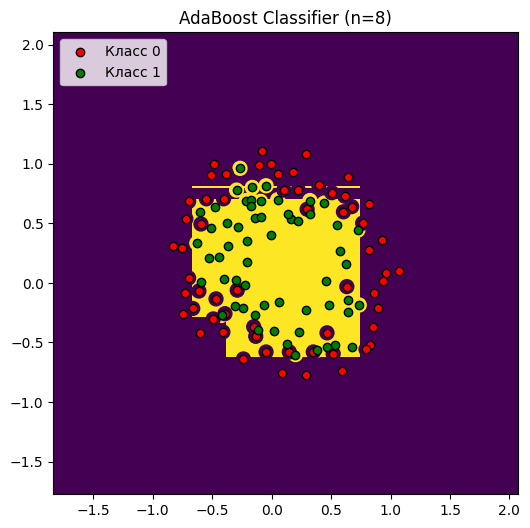

In [312]:
_ = plot_predicted("AdaBoost Classifier (n=1)", preds[0])
_ = plot_predicted(f"AdaBoost Classifier (n={max_ind // 2})", preds[max_ind // 2])
_ = plot_predicted(f"AdaBoost Classifier (n={xs[max_ind]})", preds[max_ind])